<a href="https://colab.research.google.com/github/tanerijun/Best-README-Template/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fastai

In [2]:
from fastai.vision.all import *

In [3]:
# plot_function from fastbook
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train')]

In [6]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

The folders are filled with images

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

Let's take a look at one of the images

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor.

In [9]:
array(im3)[4:10,4:10] # The 4:10 indicates we requested the rows from index 4 (inclusive) to 10 (noninclu‐ sive), and the same for the columns

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

As PyTorch tensor

In [10]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)


We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity
So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the “ideal” 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

In [13]:
three_tensors[1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255,
         254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  4

<Axes: >

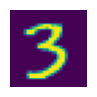

In [14]:
show_image(three_tensors[1])

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this, we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose

In [15]:
# Generally, when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

The length of a tensor’s shape is its rank:

In [16]:
len(stacked_threes.shape)

3

We can also get a tensor’s rank directly with ndim:

In [17]:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

<Axes: >

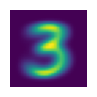

In [18]:
mean3 = stacked_threes.mean(0)
show_image(mean3) # according to this dataset, this is the ideal number 3!

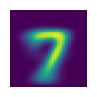

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let’s now pick an arbitrary 3 and measure its distance from our “ideal digits.”

<Axes: >

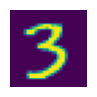

In [20]:
a_3 = stacked_threes[1]
show_image(a_3)

Two main ways to measure distance in this context:
- L1 norm (mean absolute difference): take the mean of the absolute value of differences
- L2 norm (root mean squared error (RMSE)): take the mean of the square of differences then take the square root (to undo the squaring)

Let's try both the methods:

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the “ideal” 3 is less than the distance to the ideal 7, so our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You’ll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [23]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt() # mse = mean squared error, l1 refers to the standard mathematical jargon for mean absolute value

(tensor(0.1586), tensor(0.3021))

## Quick Numpy Array and PyTorch Tensor Tutorial

In [24]:
data = [[1, 2, 3], [4, 5, 6]]
arr = array(data)
tns = tensor(data)
arr, tns

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays are identical.
You can select a row (note that, like lists in Python, tensors are 0-indexed, so 1 refers to the second row/column):

In [25]:
tns[1]

tensor([4, 5, 6])

Or a column, by using : to indicate all of the first axis (we sometimes refer to the dimensions of tensors/arrays as axes):

In [26]:
tns[:, 1] # : means selecting all rows, and the second column

tensor([2, 5])

In [27]:
tns[:, :2] # select the first 2 columns of all rows

tensor([[1, 2],
        [4, 5]])

In [28]:
tns[1, 1:3]

tensor([5, 6])

And you can use the standard operators, such as +, -, *, and /:

In [29]:
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

In [30]:
tns.type()

'torch.LongTensor'

And will automatically change that type as needed; for example, from int to float:

In [31]:
tns * 1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting
So, is our baseline any good?

So to start, let’s create tensors for our 3s and 7s from the validation data directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image

In [32]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

We ultimately want to write a function, is_3, that will decide whether an arbitrary image is a 3 or a 7. It will do this by deciding which of our two “ideal digits” that arbi‐ trary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [33]:
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2)) # The tuple (-1,-2) represents a range of axes.
mnist_distance(a_3, mean3)

tensor(0.1114)

But to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, valid_3_tens, which has a shape of [1010,28,28] representing 1,010 images.
But there is a better way.

Something interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument valid_3_tens, the tensor that represents the 3s validation set

In [34]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1183, 0.1569, 0.1464,  ..., 0.1540, 0.1360, 0.1305]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function mnist_distance, and you’ll see we have there the subtraction (a-b). The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting: it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes ten‐ sor code much easier to write.

Finally, our function calls mean((-1,-2)). The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the last element, and -2 refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was (1010). In other words, for every image, we averaged the intensity of all the pixels in that image.

## Is 3

We can use mnist_distance to figure out whether an image is a 3 by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it’s a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [35]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

Let's test it on our example case:

In [36]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Thanks to broadcasting, we can also test it on the full validation set of 3s:

In [37]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s, by taking the average of that function for all 3s and its inverse for all 7s:

In [38]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# Stochastic Gradient Descent
Here are the steps required to turn this function into a machine learning classifier:
1. Initialize the weights.
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
3. Based on these predictions, calculate how good the model is (its loss).
4. Calculate the gradient, which measures for each weight how changing that weight would change the loss.
5. Step (that is, change) all the weights based on that calculation.
6. Go back to step 2 and repeat the process.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don’t want to wait any longer).

## Calculating Gradients

The gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the derivative of a function tells you how much a change in its parameters will change its result.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. When we know how our function will change, we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative, we won’t get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight and treat all the other ones as constant, and then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

PyTorch is able to automatically compute the derivative of nearly any function! What’s more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let’s see an example.

First, let’s pick a tensor value at which we want gradients:

In [39]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [40]:
def f(x): return x**2

yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [41]:
yt.backward()

The “backward” here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer.

Life would probably be easier if backward was just called calculate_grad, but deep learning folks really do like to add jargon everywhere they can!

We can now view the gradients by checking the grad attribute of our tensor:

In [42]:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of x**2 is 2*x, and we
have x=3, so the gradients should be 2*3=6, which is what PyTorch calculated for us!

Now we’ll repeat the preceding steps, but with a vector argument for our function:

In [43]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we’ll add sum to our function so it can take a vector (i.e., a rank-1 tensor) and
return a scalar (i.e., a rank-0 tensor):

In [44]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are 2*xt, as we’d expect!

In [45]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients tell us only the slope of our function; they don’t tell us exactly how far to adjust the parameters. But they do give us some idea of how far: if the slope is very large, that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

## Stepping with a Learning Rate

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR). The learning rate is often a number between 0.001 and 0.1, although it could be any‐ thing. Often people select a learning rate just by trying a few, and finding which results in the best model after training

Once you’ve picked a learning rate, you can adjust your parameters using this simple function:
```
w -= w.grad * lr
```

## An End-to-End SGD Example

Let’s start with a simple, synthetic example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [46]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

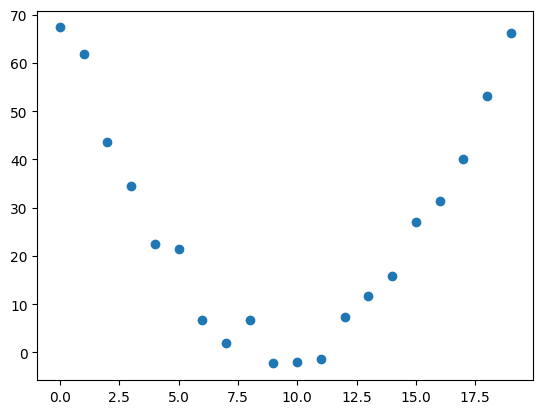

In [47]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)


We’ve added a bit of random noise, since measuring things manually isn’t precise. This means it’s not that easy to answer the question: what was the roller coaster’s speed? Using SGD, we can try to find a function that matches our observations. We can’t consider every possible function, so let’s use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

In [48]:
def f(t, params):
  a, b, c = params
  return a*(t**2) + (b*t) + c

In other words, we’ve restricted the problem of finding the best imaginable function that fits the data to finding the best quadratic function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters a, b, and c. Thus, to find the best quadratic function, we need to find only the best values for a, b, and c.

If we can solve this problem for the three parameters of a quadratic function, we’ll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let’s find the parameters for f first, and then we’ll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by “best.” We define this precisely by choosing a loss function, which will return a value based on a prediction and a target, where lower values of the function correspond to “better” predictions. For continuous data, it’s common to use mean squared error:

In [49]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our seven-steps process.

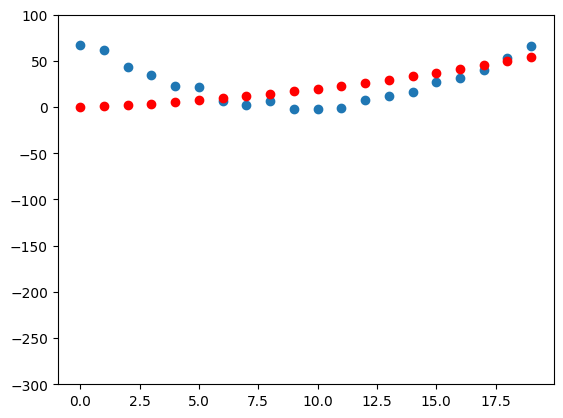

In [50]:
# Step 1
# First, we initialize the parameters to random values and tell PyTorch that we want to track their gradients using requires_grad_:
params = torch.randn(3).requires_grad_()

# Step 2: Calculate the prediction
preds = f(time, params)

# Let’s create a little function to see how close our predictions are to our targets, and take a look:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color="red")
  ax.set_ylim(-300, 100)

show_preds(preds)

In [51]:
# Step 3: Calculate the loss
# We calculate the loss as follows:
loss = mse(preds, speed)
loss

tensor(721.3581, grad_fn=<MeanBackward0>)

In [52]:
# Step 4: Calculate the gradients
# The next step is to calculate the gradients, or an approximation of how the parameters need to change:
loss.backward()
params.grad

tensor([1636.9978,  123.1542,   -8.2248])

In [53]:
params.grad * 1e-5

tensor([ 1.6370e-02,  1.2315e-03, -8.2248e-05])

We can use these gradients to improve our parameters. We’ll need to pick a learning rate (we’ll discuss how to do that in practice in the next chapter; for now, we’ll just use 1e-5 or 0.00001):

In [54]:
params

tensor([ 0.0905,  1.1358, -0.4131], requires_grad=True)

In [55]:
# Step 5: Step the weights
# Now we need to update the parameters based on the gradients we just calculated:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Let's see if the loss has improved

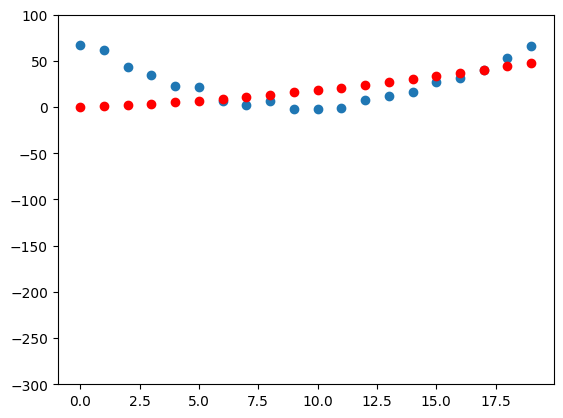

In [56]:
preds = f(time, params)
mse(preds, speed)
show_preds(preds)

We need to repeat this a few times, so we’ll create a function to apply one step

In [57]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

In [58]:
# Step 6: Repeat the process
for _ in range(10): apply_step(params)

702.019775390625
698.3558349609375
697.6580200195312
697.521240234375
697.4908447265625
697.48046875
697.4739990234375
697.4682006835938
697.4625244140625
697.4568481445312


The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data

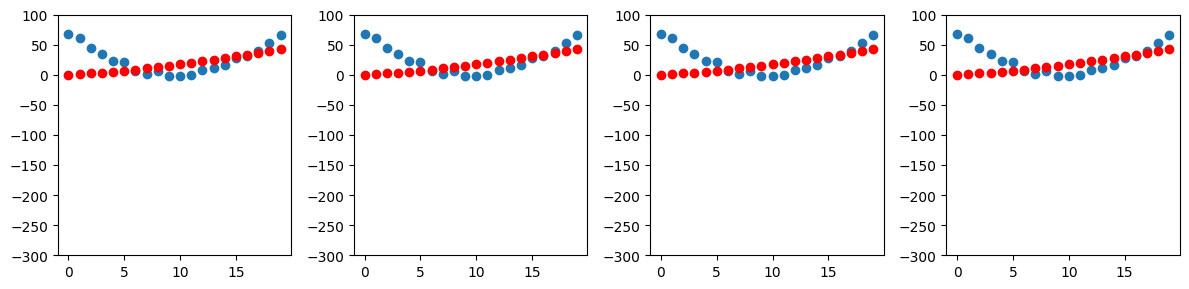

In [59]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

Step 7: Stop
We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we’ve discussed.

## The MNIST Loss Function
We already have our xs—that is, our independent variables, the images themselves. We’ll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using view, which is a PyTorch method that changes the shape of a tensor without changing its contents. -1 is a special parameter to view that means “make this axis as big as necessary to fit all the data”:

In [60]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([0]*len(stacked_threes) + [0]*len(stacked_sevens)).unsqueeze(1) # We need a label for each image. We’ll use 1 for 3s and 0 for 7s
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [61]:
# Just a refresher
test = tensor(1)
print(test.shape)
t1 = tensor([2])
print(t1.shape)
t2 = tensor([1, 2, 3])
print(t2.shape)
t3 = tensor([[1], [2]])
print(t3.shape)
t4 = tensor([[1, 2], [3, 4]])
print(t4.shape)
t5 = tensor([[1, 2, 3], [4, 5, 6]])
print(t5.shape)

torch.Size([])
torch.Size([1])
torch.Size([3])
torch.Size([2, 1])
torch.Size([2, 2])
torch.Size([2, 3])


A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function that, when combined with list, provides a simple way to get this functionality:

In [62]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([0]))

In [63]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

In [64]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28, 1))

The function `weights*pixels` won’t be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the b. We’ll initialize it to a random number too:

In [65]:
bias = init_params(1)
bias

tensor([1.4555], requires_grad=True)

In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters.

We can now calculate a prediction for one image:

In [66]:
(train_x[0]*weights.T).sum() + bias

tensor([-4.7347], grad_fn=<AddBackward0>)

While we could use a Python for loop to calculate the prediction for each image, that would be very slow. Because Python loops don’t run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there’s an extremely convenient mathematical operation that calculates w*x for every row of a matrix called matrix multiplication.

In Python, matrix multiplication is represented with the @ operator. Let’s try it:

In [67]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-4.7347],
        [-2.0439],
        [-3.9245],
        ...,
        [-9.1251],
        [ 2.2449],
        [ 7.6469]], grad_fn=<AddBackward0>)

Let’s check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it’s greater than 0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) as follows:

In [68]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [69]:
corrects.float().mean().item()

0.5136334300041199

We need a loss function that represents how good our model is.

The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this mathematically as:

```(y_new – y_old) / (x_new – x_old)```

This gives a good approximation of the gradient when x_new is very similar to x_old, meaning that their difference is very small. But accuracy changes at all only when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from x_old to x_new isn’t likely to cause any prediction to change, so (y_new – y_old) will almost always be 0. In other words, the gradient is 0 almost everywhere.

A very small change in the value of a weight will often not change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will be 0, and the model will not be able to learn from that number.

Instead, we need a loss function that, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a “slightly better prediction” look like, exactly? Well, in this case, it means that if the correct answer is a 3, the score is a little higher, or if the correct answer is a 7, the score is a little lower.

Let’s write such a function now. What form does it take?

The loss function receives not the images themselves, but the predictions from the model. So let’s make one argument, prds, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor) indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values—that is, the targets (aka labels). Let’s therefore make another argument, trgts, with values of 0 or 1 that tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor) indexed over the images.

For instance, suppose we had three images that we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (0.9) that the first was a 3, with slight confidence (0.4) that the second was a 7, and with fair confidence (0.2), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [70]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here’s a first try at a loss function that measures the distance between predictions and targets:

In [71]:
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

We’re using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

Let’s try it on our prds and trgts:

In [72]:
torch.where(trgts==1, 1 - prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, mnist_loss takes the mean of the previous tensor:

In [73]:
mnist_loss(prds, trgts)

tensor(0.4333)

For instance, if we change our prediction for the one “false” target from 0.2 to 0.8, the loss will go down, indicating that this is a better prediction:


In [74]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let’s take a look.

## Sigmoid

The sigmoid function always outputs a number between 0 and 1. It’s defined as follows:

In [75]:
def sigmoid(x): return 1/(1+torch.exp(-x))

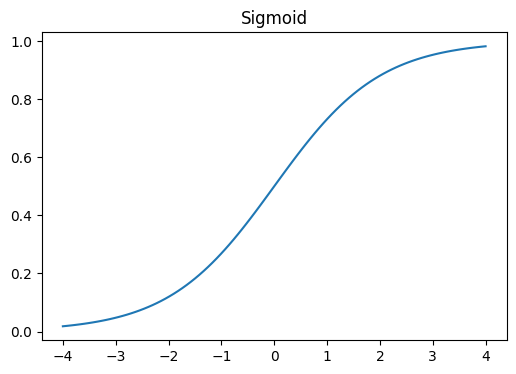

In [76]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

Let’s update mnist_loss to first apply sigmoid to the inputs:

In [77]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid() # apply sigmoid
  return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence.

## SGD and Mini-Batches

Now that we have a loss function suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an optimization step.

To take an optimization step, we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a long time. Calculating it for a single item would not use much information, so it would result in an imprecise and unstable gradient. You’d be going to the trouble of updating the weights, but taking into account only how that would improve the model’s performance on that single item.

So instead we compromise: we calculate the average loss for a few data items at a time. This is called a mini-batch. The number of data items in the mini-batch is called the batch size. A larger batch size means that you will get a more accurate and stable estimate of your dataset’s gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators perform well only if they have lots of work to do at a time, so it’s helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

We get better generalization if we can vary things during training (data augmentation). One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called DataLoader.

A DataLoader can take any Python collection and turn it into an iterator over many batches, like so:

In [78]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12, 11, 13,  4]),
 tensor([ 6,  0,  1, 10,  2]),
 tensor([14,  7,  9,  8,  5])]

For training a model, we don’t just want any Python collection, but a collection containing independent and dependent variables (the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. Here’s an example of an extremely simple Dataset:

In [79]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back many batches that are themselves tuples of tensors representing batches of independent and dependent variables:

In [80]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([22,  6, 24, 16,  8, 21]), ('w', 'g', 'y', 'q', 'i', 'v')),
 (tensor([ 7, 20,  9,  4, 18,  3]), ('h', 'u', 'j', 'e', 's', 'd')),
 (tensor([25, 13, 11, 17,  0, 23]), ('z', 'n', 'l', 'r', 'a', 'x')),
 (tensor([14,  1,  2, 10,  5, 19]), ('o', 'b', 'c', 'k', 'f', 't')),
 (tensor([15, 12]), ('p', 'm'))]

## Putting It All Together

Implement something like this

```
for x,y in dl:
  pred = model(x)
  loss = loss_func(pred, y)
  loss.backward()
  parameters -= parameters.grad * lr
```

First, let's initialize our parameters

In [81]:
weights = init_params((28 * 28, 1))
bias = init_params(1)

Create DataLoader from Dataset

In [82]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set

In [83]:
valid_dl = DataLoader(valid_dset, batch_size=256)


Let's create mini-batch of size 4 for testing

In [84]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [85]:
preds = linear1(batch)
preds

tensor([[-4.3566],
        [ 0.8908],
        [ 2.9002],
        [ 0.7436]], grad_fn=<AddBackward0>)

In [86]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.5868, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

In [87]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(0.0192), tensor([0.1217]))

Let's put all that in a function  

In [88]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

And test it

In [89]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(0.0383), tensor([0.2433]))

The gradients have changed! The reason for this is that loss.backward adds the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [90]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise, things will get confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor, PyTorch will not take the gradient of that step. Here’s our basic training loop for an epoch:

In [91]:
def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()

We also want to check how we’re doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it’s greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) as follows:

In [92]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [False],
        [False],
        [False]])

That gives us this function to calculate our validation accuracy:

In [93]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [94]:
batch_accuracy(linear1(batch), train_y[:4]) # check if it works

tensor(0.2500)

And then put the batches together:

In [95]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.5615

That’s our starting point. Let’s train for one epoch and see if the accuracy improves:

In [96]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5054

Then do a few more:

In [97]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.5063 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 

Looking good! We’re already about at the same accuracy as our “pixel similarity” approach, and we’ve created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it’s called an optimizer.

## Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our linear function with PyTorch’s nn.Linear module. A module is an object of a class that inherits from the PyTorch nn.Module class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses, and they will return the activations of a model.

nn.Linear does the same thing as our init_params and linear together. It contains both the weights and biases in a single class. Here’s how we replicate our model from the previous section:

In [98]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the parameters method:

In [99]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [100]:
class BasicOptim:
  def __init__(self, params, lr):
    self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None

We can create our optimizer by passing in the model’s parameters:

In [101]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified:

In [102]:
def train_epoch(model):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

Our validation function doesn’t need to change at all:

In [103]:
validate_epoch(linear_model)

0.3783

Let’s put our little training loop in a function, to make things simpler:

In [104]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [105]:
train_model(linear_model, 20)

0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 

fastai provides the SGD class that, by default, does the same thing as our BasicOptim:

In [106]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 

fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner, we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [107]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as cnn_learner), we need to pass in all the elements that we’ve created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [108]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                    loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call fit:

In [109]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.007130,0.495860,0.504416,00:00
1,0.002263,0.495777,0.504416,00:00
2,0.000992,0.495733,0.504416,00:00
3,0.000536,0.495706,0.504416,00:00
4,0.000346,0.495687,0.504416,00:00
5,0.000258,0.495674,0.504416,00:00
6,0.000210,0.495663,0.504416,00:00
7,0.000181,0.495655,0.504416,00:00
8,0.000161,0.495648,0.504416,00:00
9,0.000146,0.495643,0.504416,00:00


## Adding a Nonlinearity
So far, we have a general procedure for optimizing the parameters of a function, and we have tried it out on a boring function: a simple linear classifier. A linear classifier is constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear (i.e., different from ax+b) between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [110]:
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res

Here, w1 and w2 are weight tensors, and b1 and b2 are bias tensors; that is, parameters that are initially randomly initialized, just as we did in the previous section:

In [112]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)


The key point is that w1 has 30 output activations (which means that w2 must have 30 input activations, so they match). That means that the first layer can construct 30 dif‐ ferent features, each representing a different mix of pixels. You can change that 30 to anything you like, to make the model more or less complex.

That little function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU. We think we can all agree that rectified linear unit sounds pretty fancy and complicated...But actually, there’s nothing more to it than res.max(tensor(0.0))— in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as F.relu:

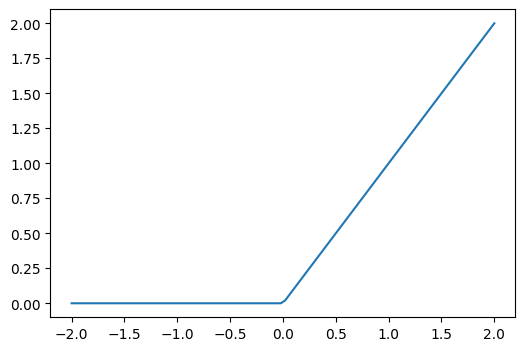

In [111]:
plot_function(F.relu)

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there’s no point in just putting one linear layout directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by mul‐ tiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as max, this is no longer true. Now each linear layer is somewhat decoupled from the other ones and can do its own useful work. The max function is particularly interesting, because it operates as a sim‐ ple if statement.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for w1 and w2 and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the universal approximation theorem. The three lines of code that we have here are known as layers. The first and third are known as linear layers, and the sec‐ ond line of code is known variously as a nonlinearity, or activation function.


Just as in the previous section, we can replace this code with something a bit simpler by taking advantage of PyTorch:


In [113]:
simple_net = nn.Sequential(
        nn.Linear(28*28,30),
        nn.ReLU(),
        nn.Linear(30,1)
)

nn.Sequential creates a module that will call each of the listed layers or functions in turn.

Because nn.Sequential is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let’s try it out! As this is a deeper model, we’ll use a lower learning rate and a few more epochs:

In [114]:
learn = Learner(dls, simple_net, opt_func=SGD,
                    loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.060256,0.498336,0.504416,00:00
1,0.019445,0.496789,0.504416,00:00
2,0.008118,0.496334,0.504416,00:00
3,0.003946,0.496122,0.504416,00:00
4,0.002218,0.496001,0.504416,00:00
5,0.001436,0.495923,0.504416,00:00
6,0.001045,0.495869,0.504416,00:00
7,0.000827,0.495829,0.504416,00:00
8,0.000691,0.495799,0.504416,00:00
9,0.000597,0.495775,0.504416,00:00


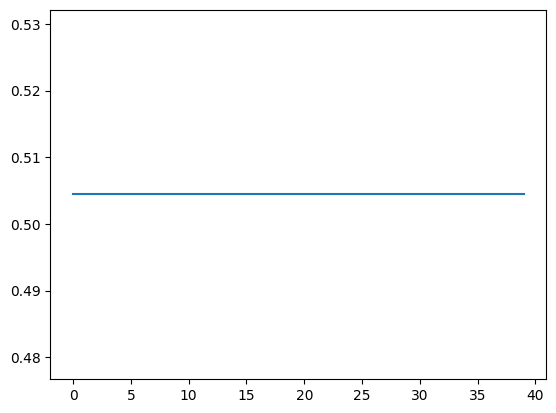

In [115]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy

In [116]:
learn.recorder.values[-1][2]

0.5044161081314087

At this point, we have something that is rather magical:
• A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
• A way to find the best set of parameters for any function (stochastic gradient descent)